In [1]:
import numpy as np
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from tqdm import tqdm
import xarray as xr 
import matplotlib.gridspec as gridspec
from matplotlib.animation import FuncAnimation
import matplotlib.cm as cm
from matplotlib import patches
from matplotlib import colors
from scipy import signal

In [41]:
actions = {
    0: {"name":"Up", "label":"↑", "delta":(-1,0), 'angle': float(np.pi)},
    1: {"name":"Right", "label":"→", "delta":(0,1), 'angle': float(3 * np.pi / 2)},
    2: {"name":"Down", "label":"↓", "delta":(1,0), 'angle': float(0.0)},
    3: {"name":"Left", "label":"←", "delta":(0,-1), 'angle': float(np.pi / 2)},
}

color_dict = {
    '0': colors.LinearSegmentedColormap.from_list("", ["white", "xkcd:ultramarine"]),
    '1': colors.LinearSegmentedColormap.from_list("", ["white", "xkcd:magenta"]),
}

In [21]:
class GridPlotter:
    def __init__(self, agent):
        self.agent = agent

    def plot_env(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(0.1 * self.agent.width, 0.1 * self.agent.height))
        ax.imshow((color_dict['0'](self.agent.env[:,:,0]) + color_dict['1'](self.agent.env[:,:,1]))/2, interpolation='gaussian', zorder=0) 
        ax.imshow(1 - self.agent.grid, cmap=cm.binary, alpha=0.25, zorder=1)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.set_xlim([self.agent.pk_hw - 1, self.agent.width - self.agent.pk_hw])
        ax.set_ylim([self.agent.height - self.agent.pk_hw, self.agent.pk_hw - 1])
        return ax 
    
    def plot_rewards(self, ax): #, reward_locations):
        for reward_location in self.agent.reward_locations:
            square_patch = patches.Rectangle((reward_location[1] - 0.5, reward_location[0] - 0.5), 1, 1, color='darkorange', zorder=2)
            ax.add_patch(square_patch)
        return ax

    def plot_agent(self, ax, agent_location):
        square_patch = patches.Rectangle((agent_location[1] - 0.5, agent_location[0] - 0.5), 1, 1, color='cornflowerblue', zorder=3)
        ax.add_patch(square_patch)
        return ax

    def plot_episode(self, episode_data, stop_at_step=None, ax=None):
        agent_path = episode_data["path"]
        stop_at_step = len(agent_path) if stop_at_step is None else stop_at_step
        
        if ax is None:
            ax = self.plot_env()
            ax = self.plot_rewards(ax)
            
        ax.set_title(f'{len(agent_path)} Steps')

        for i in range(stop_at_step):
            episode_frac = i // stop_at_step
            ax = self.plot_agent(ax, agent_location=agent_path[i])
        return ax

    def plot_training_progress(self, episode_lengths, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 4))

        n_eps = len(episode_lengths)
        smoothed_episode_lengths = [np.mean(episode_lengths[max(0, i - 100):i + 1]) for i in range(n_eps)]
        ax.scatter(np.arange(n_eps), episode_lengths, linewidth=0, alpha=0.5, c='C0', label="Episode length")
        ax.plot(np.arange(len(smoothed_episode_lengths)), smoothed_episode_lengths, color='k', linestyle="--", linewidth=0.5, label="Smoothed")
        ax.set_xlabel("Episode")
        ax.set_ylabel("Length")
        ax.legend()
        ax.set_title("Training Progress")
        return ax

    def plot_policy(self, ax=None):
        if ax is None:
            ax = self.plot_env()
            ax = self.plot_rewards(ax)

        for state, location in enumerate(self.agent.valid_states):
            action = np.argmax(self.agent.Q_value(state))
            color = plt.colormaps['twilight'](action / self.agent.n_actions)
            ax = self.plot_arrow(location[::-1], action, ax, color=color)
        return ax

    def plot_arrow(self, location, direction, ax, **kwargs):
        alpha = kwargs.get("alpha", 1)
        color = kwargs.get("color", plt.cm.viridis(0.5))
        size_scaler = kwargs.get("size_scaler", 1)
        base_triangle = np.array([[0.1, 0.1], [0.9, 0.1], [0.5, 0.9]]) - np.array([0.5, 0.5])
        scaled_triangle = base_triangle * size_scaler
        angle = self.agent.action_dict[direction]['angle']
        rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
        rotated_triangle = np.dot(scaled_triangle, rotation_matrix.T)
        translated_triangle = rotated_triangle + np.array(location)
        triangle = plt.Polygon(translated_triangle, color=color, alpha=alpha, linewidth=0)
        ax.add_patch(triangle)
        return ax

In [35]:
# class QLearnerAgent:
#     def __init__(self, env, pk_hw, gamma, alpha, epsilon, n_features, max_steps, cost_per_step, cost_per_wall_collision, reward_locations, reward_values, action_dict=small_action_dict):
#         self.env = env
#         self.grid = env[:, :, -1]
#         self.pk_hw = pk_hw
#         self.height, self.width = self.grid.shape
#         self.max_steps = max_steps
#         self.cost_per_step = cost_per_step
#         self.cost_per_wall_collision = cost_per_wall_collision
#         self.reward_locations = reward_locations
#         self.reward_values = reward_values
        
#         self.gamma = gamma
#         self.alpha = alpha
#         self.epsilon = epsilon
        
#         self.valid_states = self.get_valid_states()
#         self.action_dict = action_dict
#         self.n_features = n_features
#         self.n_states = len(self.valid_states)
#         self.n_actions = len(action_dict)
#         self.theta = np.zeros((self.n_features, self.n_actions))

#         self.plotter = GridPlotter(self)
#         self.reset()

#     def reset(self):
#         self.agent_location = (self.height // 2 + 1, self.width // 2)
#         self.agent_direction = int(0)
        
#     def get_valid_states(self):
#         return [(r, c) for r in range(self.height) for c in range(self.width) if self.grid[r, c] == 1]
        
#     def get_features(self, state):
#         features = np.zeros(self.n_features)
#         if state is not None:
#             location = self.valid_states[state]
#             features[0] = self.env[location[0], location[1], 0] # current location
#             features[1] = self.env[location[0] - 1, location[1], 0] # square up
#             features[2] = self.env[location[0] + 1, location[1], 0] # square down
#             features[3] = self.env[location[0], location[1] - 1, 0] # square left
#             features[4] = self.env[location[0], location[1] + 1, 0] # square right
#             features[5], features[6] = self.closest_reward_features(state)
#         return features
        
#     def closest_reward_features(self, state):
#         location = self.valid_states[state]
#         nearest_reward = min(self.reward_locations, key=lambda reward: np.linalg.norm(location - np.array(reward)))
#         delta = tuple(np.array(location) - np.array(nearest_reward[0]))
#         distance = float(sum(delta) / 22)
#         angle = float(np.arctan2(delta[1], delta[0]))
#         return distance, angle

#     def Q_value(self, state):
#         return np.dot(self.get_features(state), self.theta)
    
#     def learn(self, state, next_state, action, next_action, R, alpha):
#         Q = float(0.0) if (state is None or action is None) else self.Q_value(state)[action]
#         Q_next =  float(0.0) if (next_state is None or next_action is None) else self.Q_value(next_state)[next_action]
#         TD_error = float(R) + (float(self.gamma) * float(Q_next)) - float(Q)

#         if state is not None:
#             self.theta[:, action] += float(alpha) * float(TD_error) * self.get_features(state)
            
#         return TD_error

#     def step(self, action):
#         next_location = tuple(np.array(self.agent_location) + np.array(self.action_dict[action]['delta']))
#         reward = float(self.get_reward(next_location)) - float(self.cost_per_step)

#         if next_location in self.valid_states:
#             self.agent_location = next_location
#             self.agent_direction = action
#         else:
#             reward -= float(self.cost_per_wall_collision)

#         return self.location_to_state(self.agent_location), reward, (reward > 0)
    
#     def get_reward(self, location):
#         return float(self.reward_values[self.reward_locations.index(location)]) if location in self.reward_locations else float(0.0)

#     def location_to_state(self, location):
#         return int(self.valid_states.index(location)) if location in self.valid_states else None

#     def epsilon_greedy_policy(self, state, epsilon):
#         return int(np.random.randint(self.n_actions)) if np.random.rand() < epsilon else int(np.argmax(self.Q_value(state)))
    
#     def train(self, n_episodes, max_episode_length=None):
#         self.n_episodes = n_episodes
#         self.episode_history = {}
#         self.episode_lengths = []
#         decaying_alpha = self.alpha
#         decaying_epsilon = self.epsilon
            
#         max_episode_length = self.max_steps if max_episode_length is None else max_episode_length
        
#         for episode in tqdm(range(self.n_episodes)):
#             self.reset()
#             state = self.location_to_state(self.agent_location)
#             action = int(self.epsilon_greedy_policy(state, self.epsilon))
#             episode_data = {'path': [], 'states': [], 'actions': [], 'rewards': [], 'reward_locations': [location for location in self.reward_locations]}
#             terminal = False
#             step = int(0)
                
#             while not terminal and step < max_episode_length:
#                 state_next, reward, terminal = self.step(action)
#                 next_action = int(self.epsilon_greedy_policy(state_next, decaying_epsilon)) if not terminal else None
#                 self.learn(state, state_next, action, next_action, reward, decaying_alpha)
                
#                 episode_data['path'].append(self.agent_location)
#                 episode_data['states'].append(state)
#                 episode_data['actions'].append(action)
#                 episode_data['rewards'].append(reward)

#                 state = state_next
#                 action = next_action
#                 step += 1    
#                 # decaying_alpha = self.update_parameter(decaying_alpha, 0.9999, 0.05)
#                 # decaying_epsilon = self.update_parameter(decaying_epsilon, 0.9999, 0.05)

#             self.episode_history[episode] = episode_data
#             self.episode_lengths.append(step)

#     def update_parameter(self, parameter, decay_rate, parameter_min):
#         return max(parameter * decay_rate, parameter_min)

#     def produce_plots(self, training, policy, first_5_last_5):
#         if training:
#             self.plotter.plot_training_progress(episode_lengths=self.episode_lengths)
#         if policy:
#             self.plotter.plot_policy()
#         if first_5_last_5:
#             fig, axs = plt.subplots(2, 5, figsize=(10, 4))
#             for i in range(5):
#                 axs[0, i] = self.plotter.plot_env(ax=axs[0, i])
#                 axs[1, (4 - i)] = self.plotter.plot_env(ax=axs[1, (4 - i)])
#                 axs[0, i] = self.plotter.plot_rewards(ax=axs[0, i])
#                 axs[1, (4 - i)] = self.plotter.plot_rewards(ax=axs[1, (4 - i)])
                
#                 self.plotter.plot_episode(self.episode_history[i], ax=axs[0, i])
#                 self.plotter.plot_episode(self.episode_history[self.n_episodes - i - 1], ax=axs[1, (4 - i)])

In [ ]:
# width=21
# height=21
# pk = 30
# pk_hw = 15

# env = np.zeros((height, width, 3))
# for r in range(height):
#     for c in range(width):
#         if r < 2:  
#             env[r, c, -1] = 1.0
#         elif c >= (r - 1) and c < width - (r - 1):
#             env[r, c, -1] = 1.0
# env = np.pad(env, pad_width=((pk_hw, pk_hw), (pk_hw, pk_hw), (0, 0)))

# reward_locations = [(pk_hw, pk_hw + np.random.choice(range(width)))]

# for reward in reward_locations:
#     k1d = signal.windows.gaussian(pk, std=6)
#     k2d = np.outer(k1d, k1d)
#     r, c = reward
#     cue_top = r - pk_hw
#     cue_bottom = r + pk_hw
#     cue_left = c - pk_hw
#     cue_right = c + pk_hw
#     env[cue_top: cue_bottom, cue_left: cue_right, 0] += k2d[:cue_bottom - cue_top, :cue_right - cue_left] * env[cue_top: cue_bottom, cue_left: cue_right, -1]

In [ ]:
class QLearnerAgent:
    def __init__(self, env, channels, actions, location, prey_locations, sensor_noise_scale, n_steps, n_features, cost_per_step, cost_per_collision, alpha, epsilon, gamma):
        self.env = env
        self.channels = np.array(channels)
        self.actions = actions
        self.location = np.array(location)
        self.prey_locations = prey_locations
        self.sensor_noise_scale = sensor_noise_scale
        self.n_steps = n_steps
        
        self.n_features = n_features
        self.n_actions = len(actions)
        self.cost_per_step = cost_per_step
        self.cost_per_collision = cost_per_collision
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma

        self.theta = np.zeros((n_features, self.n_actions))
        self.plotter = GridPlotter(self)
        
    def reset(self):
        self.agent_location = (self.height // 2 + 1, self.width // 2)
        self.agent_direction = int(0)
        
    def sense_features(self, location):
        def closest_prey_features(self, location):
            nearest_prey = min(self.prey_locations, key=lambda reward: np.linalg.norm(location - np.array(reward)))
            delta = tuple(np.array(location) - np.array(nearest_prey[0]))
            distance = float(sum(delta) / 22)
            angle = float(np.arctan2(delta[1], delta[0]))
            return distance, angle

        features = np.zeros(self.n_features)
        distance, angle = closest_prey_features(location)
        features[0] = self.env[location[0] - 1, location[1], 0]
        features[1] = self.env[location[0] + 1, location[1], 0]
        features[2] = self.env[location[0], location[1] - 1, 0]
        features[3] = self.env[location[0], location[1] + 1, 0]
        features[4] = distance
        features[5] = angle
        return features
        
    def act(self, action):
        next_location = tuple(np.array(self.location) + np.array(self.action_dict[action]['delta']))
        
        if self.grid[next_location] == 1:
            reward = (100.0 + self.cost_per_step) if next_location in self.prey_locations else self.cost_per_step
        else:
            next_location = self.location
            reward = float(self.cost_per_collision)

        return next_location, reward
    
    def policy(self):
        decaying_alpha = self.alpha
        decaying_epsilon = self.epsilon
        
        action = int(self.epsilon_greedy_policy(self.location, self.epsilon))        
        next_location, reward = self.act(action)
        next_action = int(self.epsilon_greedy_policy(next_location, decaying_epsilon))
        
        self.learn(self.location, next_location, action, next_action, reward, decaying_alpha)
        
        self.location = next_location
        action = next_action
        ## decaying_alpha = self.update_parameter(decaying_alpha, 0.9999, 0.05)
        ## decaying_epsilon = self.update_parameter(decaying_epsilon, 0.9999, 0.05)

    def train(self):
        n_trials = 4000
        decaying_alpha = self.alpha
        decaying_epsilon = self.epsilon
        self.training_trials = {}
        self.trial_lengths = []
            
        for trial in tqdm(range(n_trials)):
            self.reset()
            action = int(self.epsilon_greedy_policy(self.location, self.epsilon))
            trial_data = {'path': [], 'actions': [], 'rewards': [], 'prey_locations': [[location for location in self.prey_locations]]}
            prey_count = len(trial_data['prey_locations'][0])
            step = int(0)
                
            while prey_count > 0 and step < self.n_steps:
                next_location, reward = self.step(action)
                current_prey_locations = trial_data['prey_locations'][step]

                if next_location in current_prey_locations:
                    prey_count -= 1
                    trial_data['prey_location'].append([location for location in current_prey_locations if location != next_location])

                trial_data['path'].append(self.location)
                trial_data['actions'].append(action)
                trial_data['rewards'].append(reward)

                if prey_count > 0:
                    next_action = int(self.epsilon_greedy_policy(next_location, decaying_epsilon))
                    self.learn(self.location, next_location, action, next_action, reward, decaying_alpha)
                    
                    # decaying_alpha = self.update_parameter(decaying_alpha, 0.9999, 0.05)
                    # decaying_epsilon = self.update_parameter(decaying_epsilon, 0.9999, 0.05)
                    self.location = next_location
                    action = next_action
                    step += 1 
                    
            self.training_trials[trial] = trial_data
            self.trial_lengths.append(step)

    def learn(self, location, next_location, action, next_action, reward, alpha):
        Q = float(self.Q_value(location)[action])
        Q_next =  float(self.Q_value(next_location)[next_action])
        TD_error = float(reward) + (float(self.gamma) * float(Q_next)) - float(Q)
        self.theta[:, action] += float(alpha) * float(TD_error) * self.get_features(location)            
        return TD_error

    def Q_value(self, location):
        return np.dot(self.get_features(location), self.theta)

    def epsilon_greedy_policy(self, location, epsilon):
        return int(np.random.randint(self.n_actions)) if np.random.rand() < epsilon else int(np.argmax(self.Q_value(location)))
    
    def update_parameter(self, parameter, decay_rate, parameter_min):
        return max(parameter * decay_rate, parameter_min)
    
    def produce_training_plots(self, training, policy, first_5_last_5):
        if training:
            self.plotter.plot_training_progress(episode_lengths=self.episode_lengths)
        if policy:
            self.plotter.plot_policy()
        if first_5_last_5:
            fig, axs = plt.subplots(2, 5, figsize=(10, 4))
            for i in range(5):
                axs[0, i] = self.plotter.plot_env(ax=axs[0, i])
                axs[1, (4 - i)] = self.plotter.plot_env(ax=axs[1, (4 - i)])
                axs[0, i] = self.plotter.plot_rewards(ax=axs[0, i])
                axs[1, (4 - i)] = self.plotter.plot_rewards(ax=axs[1, (4 - i)])
                
                self.plotter.plot_episode(self.episode_history[i], ax=axs[0, i])
                self.plotter.plot_episode(self.episode_history[self.n_episodes - i - 1], ax=axs[1, (4 - i)])

100%|██████████| 4000/4000 [00:18<00:00, 215.97it/s]


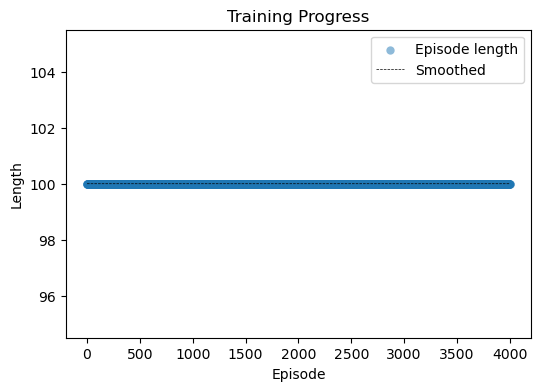

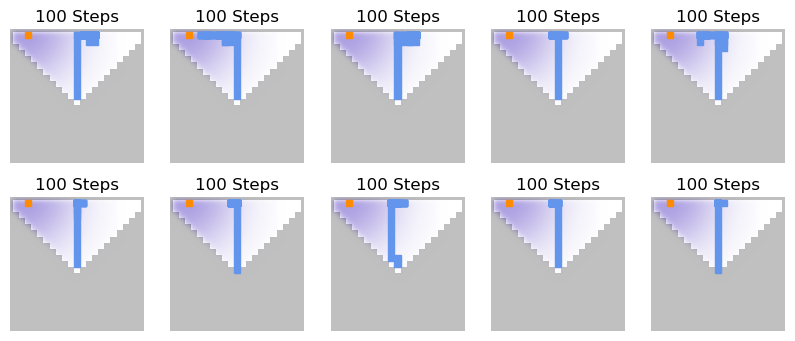

In [40]:
agent = QLearnerAgent(
    env = env,
    pk_hw = int(pk_hw),
    max_steps = int(100),
    reward_locations = reward_locations,
    reward_values = [float(50)],
    cost_per_step = float(0.0),
    cost_per_wall_collision = float(0.0),
    alpha = float(0.1),
    gamma = float(0.9),
    epsilon = float(0.1),
    n_features = int(7),
)

agent.train(
    n_episodes = int(4000),
)

agent.produce_plots(training=True, policy=False, first_5_last_5=True)
